In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from astropy.io import fits
import scipy.sparse
import scipy.linalg
import time

from astropy.io import fits

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
eV_to_erg = 1.6022e-12
parsec_to_cm = 3.085677581e18 # cm per parsec

kB = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G
e = 2.718281828459 # base of natural log

z = 2
z2 = (1 + z) / 3
T_CMB *= 1+z # scale to CMB temperature at that redshift

In [2]:
with open('rate_z2_10Mpc_new.pkl', 'rb') as f:
    rata_arr = pkl.load(f)
    
rate_arr = np.array(rata_arr)
rate_arr = rate_arr.reshape(400,400) # [i][j]: gamma[i] theta[j], rate_arr[-1] = nan
rate_trans = np.transpose(rate_arr) # [i][j]: theta[i] gamma[j], rate_trans[i][-1] = nan
rate_trans[:,-1]=0. # remove nan
#fits.PrimaryHDU(rate_trans).writeto('rate_trans.fits', overwrite=True)

gamma_e_arr = np.logspace(8, 14, 400) * eV_to_erg / m_e / c**2 # lab-frame Lorentz factor of the electron produced
theta_e_arr = np.logspace(-8,0, 400)

### generate theta_rms

### read theta_rms directly

In [3]:
prefix_sums = np.load("prefix_sums_new.npy")
print(prefix_sums[0], prefix_sums[-1])

9.9066004556493e-11 7.154739952002411e-20


In [4]:
def calculate_solid_angles(theta):
    # theta_half[i] = theta[i-1/2]
    theta_half = (theta[1:] + theta[:-1]) / 2
    theta_half = np.concatenate([[theta[0]/2], theta_half, [3*theta[-1]/2 - theta[-2]/2]])

    Omega = 2 * np.pi * (theta_half[2:]**2 - theta_half[:-2]**2) / 2  # solid angles of annulus
    Omega = np.concatenate([Omega, [2 * np.pi * (theta[-1]**2 - theta_half[-2]**2)]])  # add the last circle

    return Omega, theta_half

In [5]:
Omega, theta_half = calculate_solid_angles(theta_e_arr)

In [6]:
M = np.zeros((400, 400))

for i in range(400):
    for j in range(400):
        if j == i + 1:
            M[i, j] = -2 * np.pi / Omega[i] * theta_half[i+1] / (theta_e_arr[i+1] - theta_e_arr[i])
        if j == i - 1:
            M[i, j] = -2 * np.pi / Omega[i] * theta_half[i] / (theta_e_arr[i] - theta_e_arr[i-1])
for i in range(1,399):
    M[i, i] = 2 * np.pi / Omega[i] * (theta_half[i+1] / (theta_e_arr[i+1] - theta_e_arr[i]) + theta_half[i] / (theta_e_arr[i] - theta_e_arr[i-1]))

M[0,0] = -M[1,0]*Omega[1]/Omega[0]
M[-1,-1] = -M[-2,-1]*Omega[-2]/Omega[-1]

In [7]:
P = np.diag(np.sqrt(1/Omega))
L = np.linalg.inv(P)@M@P
eigenvalues_L, eigenvectors_L = np.linalg.eigh(L)
R_L = eigenvectors_L.copy()
lambda_l = eigenvalues_L.copy()

### new element of columb

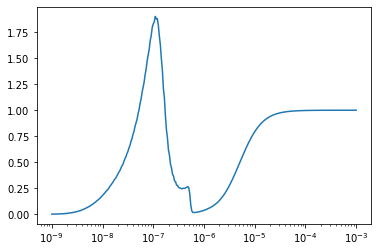

In [8]:
F_NP = np.loadtxt('fnpk_z2_new.dat')
k_prep = F_NP[:, 0]
fnpk = F_NP[:, 1]
plt.plot(k_prep, fnpk)
plt.xscale('log')
plt.show()

In [9]:
print(max(fnpk))

1.9013292305894944


In [10]:
dk = np.array([F_NP[:, 0][i] - F_NP[:, 0][i-1] for i in range(1, 301)])
dk = np.insert(dk, 0, 0)

k_cut = F_NP[:, 0][-1] # suppose, as long as k_cut at fnpk ~1 region, doesn't matter of value choosen
print(k_cut)

0.001


In [11]:
omega_b = omega_b_0 * (1 + z)**3
mean_n_b = 3 * omega_b * H_0 * H_0 / (8 * np.pi * G * m_p) # mean number density of baryons at the redshift
n_b = mean_n_b # for mean density
    
n_H = n_b * (1 - Y_He) # nuclei in hydrogen
n_He = n_H * f_He # nuclei in helium, assume He is all 4He

n_e = n_H + 2 * n_He # for fully ionized

In [16]:
nsp = 3 # number of species
mass_sp = np.array([m_e, m_p, 4*m_p]) # masses
nth_sp = np.array([n_e,n_H,n_He]) # number densities
Z_sp = np.array([-1.,1.,2.]) # charges

Z_proj = 1

def T_vectorized(gamma, l): # eq 37
    p_proj = m_e * c * gamma
    #print('p_proj', p_proj.shape)
    v_proj = c / gamma
    #print('v_proj', v_proj.shape)
    co = 2 * np.pi * l**2 * Z_proj**2 * e**4 / (p_proj**2 * v_proj)
    #print('co', co.shape)
    
    ## vectorize
    gamma_E = np.euler_gamma # Euler's constant
    sum_nsp = np.zeros(gamma.shape) # Initialize sum_nsp as an array of zeros with the same shape as gamma
    
    for a in range(nsp):
        int_FNP = np.sum(dk * F_NP[:, 1] / F_NP[:, 0] + 1 - gamma_E - np.log(h/2/np.pi * k_cut * l / p_proj[:, np.newaxis]), axis=1)
        #print('int_FNP', int_FNP.shape)
        sum_isp = Z_sp[a]**2 * nth_sp[a] * int_FNP
        sum_nsp += sum_isp
    
    return co * sum_nsp

In [13]:
def T_ij(l, i ,j): # eq 39 bracket part
    print('l', l)
    Gamma_IC0 = 1.1e-18 * z2**4
    gamma_ij = gamma_e_arr[i:j+1]
    print('gamma_ij', gamma_ij.shape)
    d_gamma_e = np.insert(np.diff(gamma_ij), 0, 0)
    Tl = T_vectorized(gamma_ij, l)
    #print(Tl.shape, d_gamma_e.shape, gamma_ij.shape)
    return -np.sum(Tl * d_gamma_e / Gamma_IC0 / gamma_ij**2) # exp(T_ij)

In [14]:
l = np.sqrt(lambda_l)
print(l)

[           nan            nan            nan 2.61990748e+00
 6.13877552e+00 9.38494161e+00 1.25299003e+01 1.55841304e+01
 1.85373811e+01 2.13723695e+01 2.40659680e+01 2.44389448e+01
 2.60322776e+01 2.65837261e+01 2.88526365e+01 3.06860719e+01
 3.22259533e+01 3.29502262e+01 3.41013196e+01 3.62493818e+01
 3.85989251e+01 4.11682189e+01 4.35147395e+01 4.39925454e+01
 4.71182337e+01 4.74919549e+01 5.06073721e+01 5.45469451e+01
 5.50028208e+01 5.58945689e+01 5.90665533e+01 6.36673628e+01
 6.43775906e+01 7.08796735e+01 7.27976301e+01 7.69186368e+01
 7.83304970e+01 7.95852677e+01 8.62874714e+01 9.29032708e+01
 9.80059497e+01 9.97149591e+01 1.07862769e+02 1.13349862e+02
 1.19005245e+02 1.19859886e+02 1.29789392e+02 1.30610792e+02
 1.36460418e+02 1.40676900e+02 1.47527236e+02 1.54497637e+02
 1.62190848e+02 1.69534615e+02 1.76083821e+02 1.85562671e+02
 1.95523753e+02 2.14242282e+02 2.23620079e+02 2.24320573e+02
 2.34821028e+02 2.45967864e+02 2.69872500e+02 2.70461462e+02
 2.82785853e+02 3.051541

/var/folders/k2/qxng019s7y17hp_kgkzy9b180000gn/T/ipykernel_76825/2296288356.py:1: RuntimeWarning: invalid value encountered in sqrt
  l = np.sqrt(lambda_l)


In [17]:
print(T_ij(l[0], 0, 1))
print(T_ij(l[0], 0, 399))
print(T_ij(l[0], 398, 399))
print(T_ij(l[3], 0, 1))
print(T_ij(l[3], 0, 399))
print(T_ij(l[3], 398, 399))
print(T_ij(l[-1], 0, 1))
print(T_ij(l[-1], 0, 399))
print(T_ij(l[-1], 398, 399))

l nan
gamma_ij (2,)
nan
l nan
gamma_ij (400,)
nan
l nan
gamma_ij (2,)
nan
l 2.619907481456147
gamma_ij (2,)
-1.0888931087349424e+37
l 2.619907481456147
gamma_ij (400,)
-1.6494902011559505e+38
l 2.619907481456147
gamma_ij (2,)
-1.6176563157534993e+25
l 2576758400.8376894
gamma_ij (2,)
-4.420895893396106e+54
l 2576758400.8376894
gamma_ij (400,)
-6.820541768809201e+55
l 2576758400.8376894
gamma_ij (2,)
-9.097508410371333e+42
